In [1]:
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# import matplotlib.colors as mcolors
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import os
# from pykrige.ok import OrdinaryKriging
# import pykrige.kriging_tools as kt
# from pykrige.kriging_tools import write_asc_grid
# import gstools as gs

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import Rbf, RBFInterpolator
import gstools as gs
from matplotlib import cm

In [2]:
data_file = "../../../../data/one_day_data/2020/08/2020-08-01"
df = pd.read_csv(data_file + '/4-30.csv', index_col=0)
df.head()

,LON,LAT,hour-rain,AT1,RH1,SOL,WD1,WS1,PRS,SLP
Vlz-Bagbaguin_00174731,121.0009,14.7134,0.0,28.200000,53.200000,27.000000,226.000000,2.000000,1007.600000,1010.500000
NagNayon_00181273,121.0285,14.7192,0.0,29.400000,54.600000,54.000000,173.000000,0.600000,1004.800000,1011.100000
Sinegue_00181300,120.9319,14.4599,39.0,24.800000,81.500000,41.000000,89.000000,0.200000,1008.900000,1010.600000
DLSAU_00174722,120.9974,14.6705,0.0,26.532066,73.482975,178.104132,148.930579,0.326116,1008.667273,1011.166942
ASTI_00173457,121.0721,14.6471,0.0,28.600000,51.400000,219.000000,320.000000,3.200000,1002.800000,1010.500000


------------------------------ linear ------------------------------


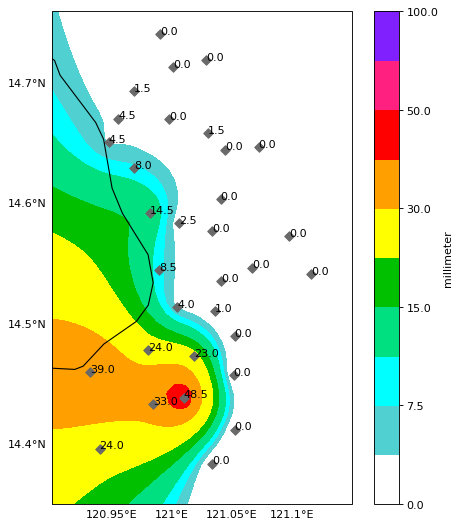

------------------------------ thin_plate_spline ------------------------------


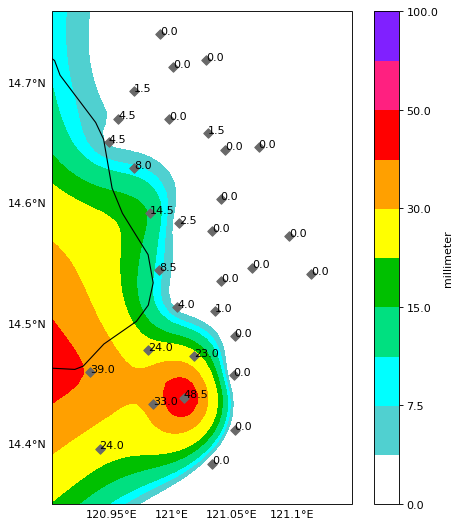

------------------------------ cubic ------------------------------


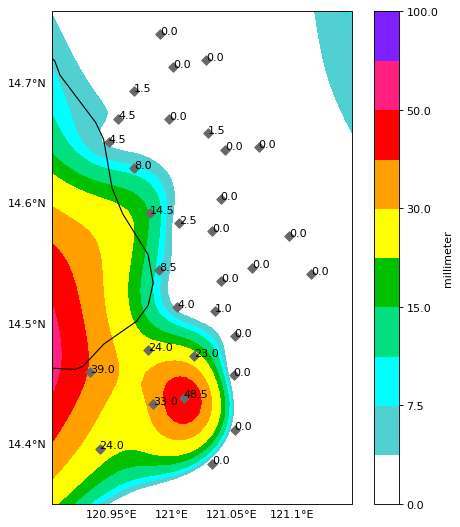

------------------------------ quintic ------------------------------


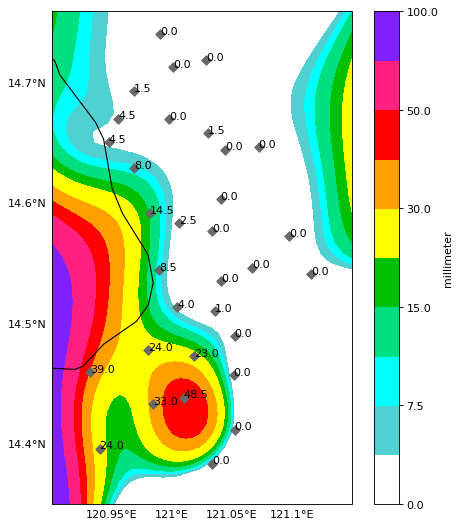

------------------------------ multiquadric ------------------------------


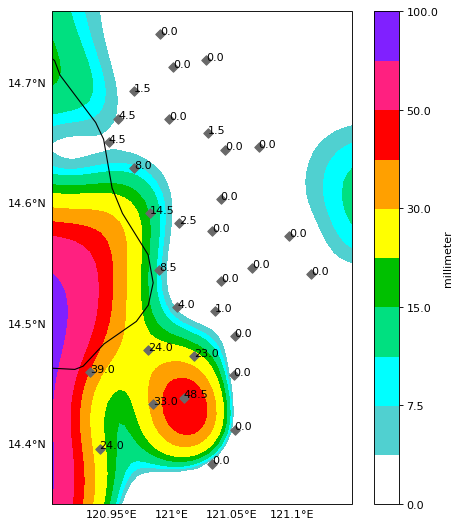

------------------------------ inverse_multiquadric ------------------------------


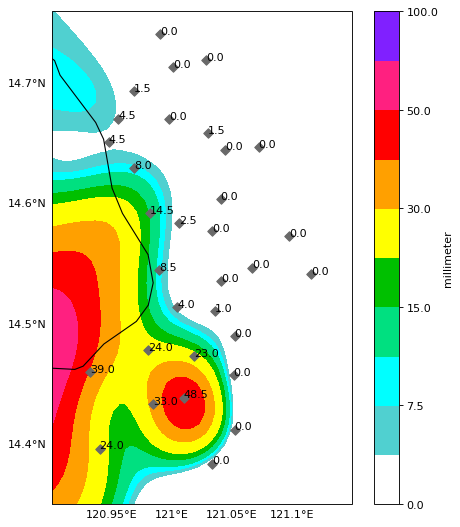

------------------------------ inverse_quadratic ------------------------------


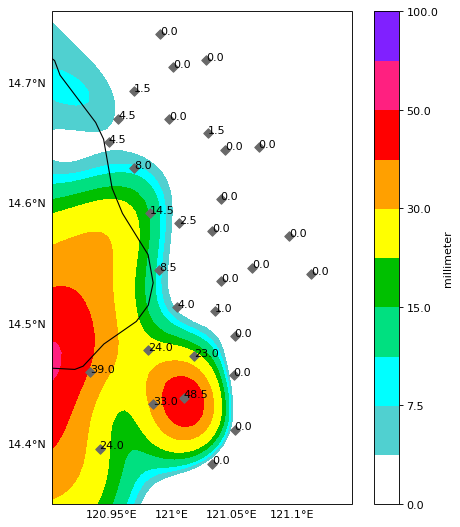

------------------------------ gaussian ------------------------------


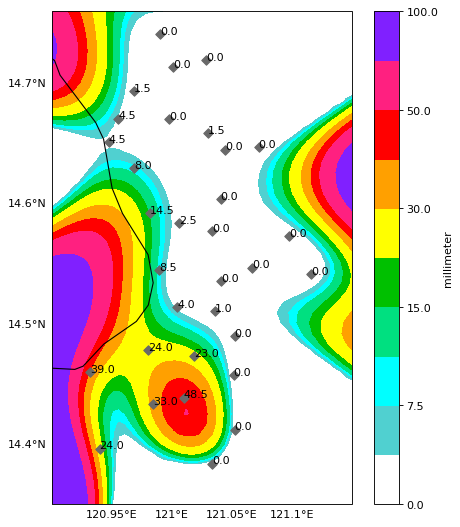

In [3]:
def custom_scaler(min_val, max_val, arr):
    return (arr - min_val) / (max_val - min_val)

def rescaler(min_val, max_val, arr):
    return arr * (max_val - min_val) + min_val

def rbf_test(kernel):
    print('-'*30, kernel, '-'*30)
    rbfi = RBFInterpolator(y=df[['LON','LAT']].values,d=df['hour-rain'].values, kernel=kernel, epsilon=10)
    grid_lon = np.round(np.linspace(120.90, 121.150, 50), decimals=3)
    grid_lat = np.round(np.linspace(14.350, 14.760, 50), decimals=3)

    
    xi, yi = np.meshgrid(grid_lon, grid_lat)
    xgrid = np.around(np.mgrid[120.90:121.150:50j, 14.350:14.760:50j], decimals=3)

    xfloat = np.around(xgrid, decimals=3).reshape(2, -1).T
    
    xmi, ymi = xfloat[:, 0], xfloat[:, 1]
    
    z1 = rbfi(xfloat)
    z1 = z1.reshape(50, 50)
    rain_data = np.where(z1 > 100, 100, z1)
    rain_data = np.where(rain_data < 0, 0, rain_data)
    
    fig = plt.figure(figsize=(7, 8), dpi=80)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([120.90, 121.150, 14.350, 14.760])
    ax.add_feature(cfeature.COASTLINE)
    gl = ax.gridlines(draw_labels=True, alpha=0)
    gl.right_labels = False
    gl.top_labels = False
    
    clevs = [0, 5, 7.5, 10, 15, 20, 30, 40, 50, 70, 100]
    cmap_data = [(1.0, 1.0, 1.0),
                (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
                (0.0, 1.0, 1.0),
                (0.0, 0.8784313797950745, 0.501960813999176),
                (0.0, 0.7529411911964417, 0.0),
                (0.501960813999176, 0.8784313797950745, 0.0),
                (1.0, 1.0, 0.0),
                (1.0, 0.6274510025978088, 0.0),
                (1.0, 0.0, 0.0),
                (1.0, 0.125490203499794, 0.501960813999176),
                (0.9411764740943909, 0.250980406999588, 1.0),
                (0.501960813999176, 0.125490203499794, 1.0),
                ]
    cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
    norm = mcolors.BoundaryNorm(clevs, cmap.N)

    cs = ax.contourf(*xgrid, rain_data, clevs, cmap=cmap, norm=norm)
    
    cbar = plt.colorbar(cs, orientation='vertical')
    cbar.set_label('millimeter')
    ax.scatter(df['LON'], df['LAT'], marker='D', color='dimgrey')
    for i, val in enumerate(df['hour-rain']):
        ax.annotate(val, (df['LON'][i], df['LAT'][i]))
    plt.show()
    plt.close()
kernels = ['linear', 'thin_plate_spline', 'cubic', 'quintic', 'multiquadric', 'inverse_multiquadric', 'inverse_quadratic', 'gaussian']
for kernel in kernels:
    rbf_test(kernel)

In [100]:
print('-'*30, kernel, '-'*30)
rbfi = RBFInterpolator(y=df[['LON','LAT']],d=df['hour-rain'], kernel='gaussian', epsilon=61)
grid_lon = np.round(np.linspace(120.90, 121.150, 50), decimals=3)
grid_lat = np.round(np.linspace(14.350, 14.760, 50), decimals=3)
xi, yi = np.meshgrid(grid_lon, grid_lat)
xgrid = np.around(np.mgrid[120.90:121.150:50j, 14.350:14.760:50j], decimals=3)
xfloat = np.around(xgrid, decimals=3).reshape(2, -1).T

xmi, ymi = xfloat[:, 0], xfloat[:, 1]

z1 = rbfi(xfloat)
z1 = z1.reshape(50, 50)
rain_data = np.where(z1 > 100, 100, z1)
rain_data = np.where(rain_data < 0, 0, rain_data)
rain_data = rain_data

save_df = pd.DataFrame(rain_data)
save_df = save_df[save_df.columns[::-1]].T
save_df.columns = grid_lon
save_df.index = grid_lat[::-1]
# print(save_df.loc[14.609, 121.140])
print(df.loc[df['hour-rain'] == df['hour-rain'].max()][['LON', 'LAT']])
save_df.to_csv('test.csv')
# save_df.describe()
cols = save_df.columns.tolist()
save_df[cols[15:]].describe()

------------------------------ gaussian ------------------------------
                            LON      LAT
Vlz-Punturin_00174725  120.9899  14.7409


,120.977,120.982,120.987,120.992,120.997,121.002,121.007,121.012,121.017,121.022,...,121.104,121.109,121.114,121.119,121.124,121.130,121.135,121.140,121.145,121.150
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,5.205851,6.053846,7.052669,7.814653,8.040939,7.689581,6.972809,6.183143,5.504176,4.942213,...,4.080962,4.144976,4.204021,4.277261,4.369137,4.481726,4.554323,4.599250,4.621551,4.630507
std,4.802015,6.949647,8.684516,9.475038,9.276906,8.465641,7.408470,6.288914,5.316824,4.741425,...,1.040513,0.995483,1.018786,0.952124,0.757369,0.453748,0.241710,0.106955,0.039301,0.011991
min,0.204956,0.027612,0.000000,0.000000,0.111558,0.015619,0.022051,0.303086,0.221422,0.313229,...,1.330106,0.651030,0.038652,0.208322,1.087611,2.504780,3.499351,4.132051,4.449809,4.578098
25%,2.842808,2.391389,2.191796,1.979376,2.222541,2.145810,2.096002,2.042258,2.322896,2.225083,...,4.371087,4.425210,4.528868,4.557834,4.606045,4.628402,4.632161,4.634013,4.634364,4.634420
50%,4.047237,3.885869,4.103392,4.229202,4.340735,4.414338,4.339449,4.026666,3.878270,3.524254,...,4.634231,4.634395,4.634416,4.634426,4.634429,4.634429,4.634429,4.634429,4.634429,4.634429
75%,4.652055,6.431340,8.907439,12.238065,11.663894,9.849035,8.172313,6.600429,5.264744,4.792633,...,4.634413,4.634427,4.634429,4.634429,4.634429,4.634429,4.634429,4.634429,4.634429,4.634429
max,23.506422,32.450134,38.689684,39.282070,33.957551,26.987300,24.671935,23.120962,19.599568,19.886226,...,4.634429,4.634429,4.634429,4.634429,4.634429,4.634429,4.634429,4.634429,4.634429,4.634429


In [4]:
# Gtools with lon lat
bins = gs.standard_bins((df['LAT'], df['LON']), max_dist=np.deg2rad(0.5), latlon=True)
bin_c, vario = gs.vario_estimate((df['LAT'], df['LON']), df['hour-rain'], bins, latlon=True)
model = gs.Exponential(latlon=True, rescale=gs.EARTH_RADIUS, var=1.0, len_scale=1.0)
model.fit_variogram(bin_c, vario, nugget=False)
ax = model.plot("vario_yadrenko", x_max=bins[-1])
ax.scatter(bin_c, vario)
print(model)

Exponential(latlon=True, var=1.38e+02, len_scale=12.6, nugget=0.0, rescale=6.37e+03)


/home/akira/anaconda3/envs/p-poteka/lib/python3.7/site-packages/gstools/covmodel/plot.py:156: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(75, 75)


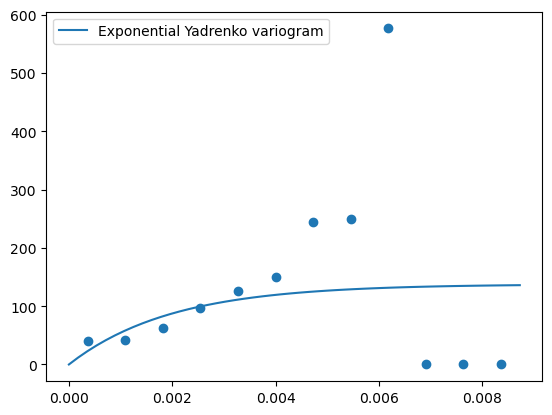

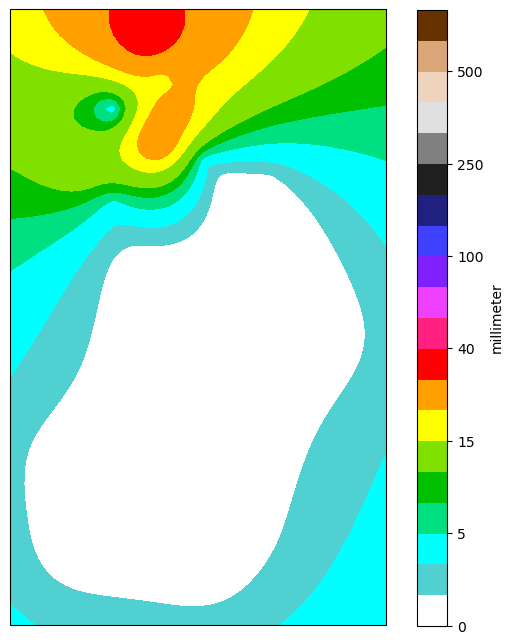

In [5]:
grid_lon = np.round(np.linspace(120.90, 121.150, 75), decimals=3)
grid_lat = np.round(np.linspace(14.350, 14.760, 75), decimals=3)
#z1, ss1 = np.round(OK.execute("grid", grid_lon, grid_lat), decimals=3)
OK_gs = gs.krige.Ordinary(model, [df['LAT'], df['LON']], df['hour-rain'], exact=True)
z1 = OK_gs.structured([grid_lat, grid_lon])
z1 = z1[0]

print(z1.shape)
xintrip, yintrip = np.meshgrid(grid_lon, grid_lat)
rain_data = np.where(z1 > 0, z1, 0)
fig = plt.figure(figsize=(8, 8))
proj = ccrs.Stereographic(central_latitude=14.555, central_longitude=121.025)
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.coastlines()

clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
         50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750]
cmap_data = [(1.0, 1.0, 1.0),
             (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
             (0.0, 1.0, 1.0),
             (0.0, 0.8784313797950745, 0.501960813999176),
             (0.0, 0.7529411911964417, 0.0),
             (0.501960813999176, 0.8784313797950745, 0.0),
             (1.0, 1.0, 0.0),
             (1.0, 0.6274510025978088, 0.0),
             (1.0, 0.0, 0.0),
             (1.0, 0.125490203499794, 0.501960813999176),
             (0.9411764740943909, 0.250980406999588, 1.0),
             (0.501960813999176, 0.125490203499794, 1.0),
             (0.250980406999588, 0.250980406999588, 1.0),
             (0.125490203499794, 0.125490203499794, 0.501960813999176),
             (0.125490203499794, 0.125490203499794, 0.125490203499794),
             (0.501960813999176, 0.501960813999176, 0.501960813999176),
             (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
             (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
             (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
             (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
             (0.4000000059604645, 0.20000000298023224, 0.0)]
cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
norm = mcolors.BoundaryNorm(clevs, cmap.N)

cs = ax.contourf(xintrip, yintrip, rain_data, clevs, cmap=cmap, norm=norm)
cbar = plt.colorbar(cs, orientation='vertical')
cbar.set_label('millimeter')
plt.show()
plt.close()

---------------------------------------- Gaussian ----------------------------------------


/home/akira/anaconda3/envs/p-poteka/lib/python3.7/site-packages/gstools/covmodel/tools.py:525: AttributeWarning: Dimension 3 is not appropriate for this model.
  AttributeWarning,
/home/akira/anaconda3/envs/p-poteka/lib/python3.7/site-packages/gstools/covmodel/plot.py:156: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


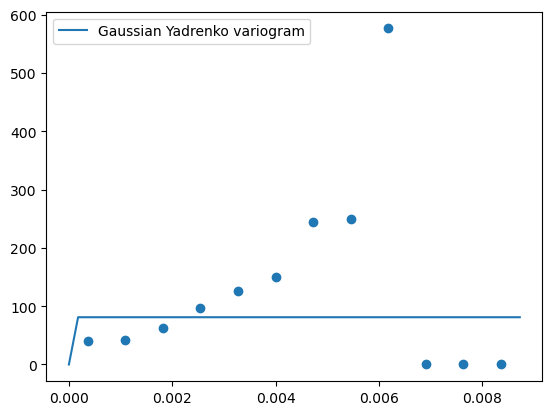

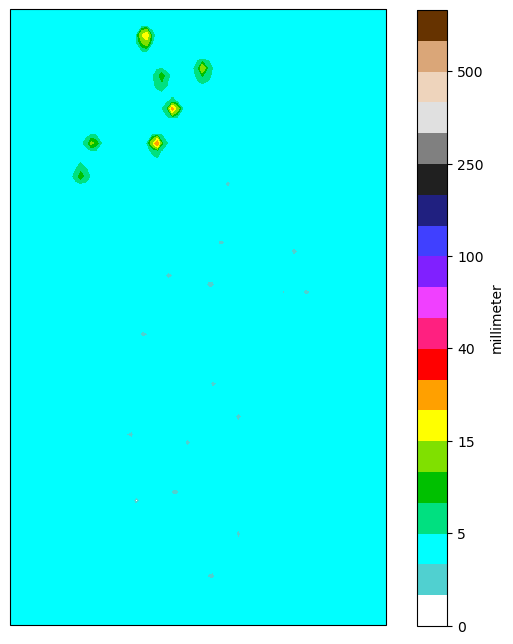

---------------------------------------- Exponential ----------------------------------------


/home/akira/anaconda3/envs/p-poteka/lib/python3.7/site-packages/gstools/covmodel/plot.py:156: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


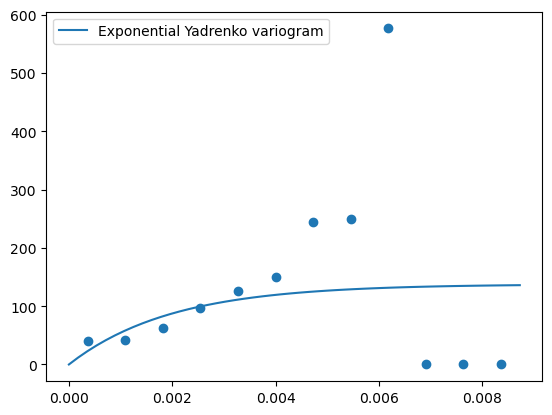

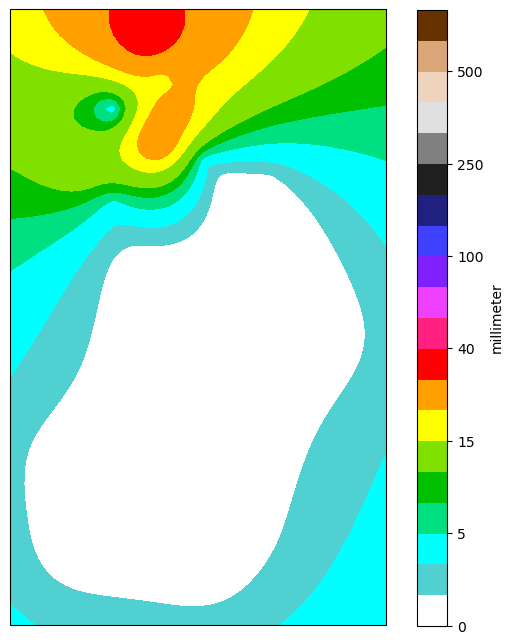

---------------------------------------- Matern ----------------------------------------


/home/akira/anaconda3/envs/p-poteka/lib/python3.7/site-packages/gstools/covmodel/plot.py:156: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


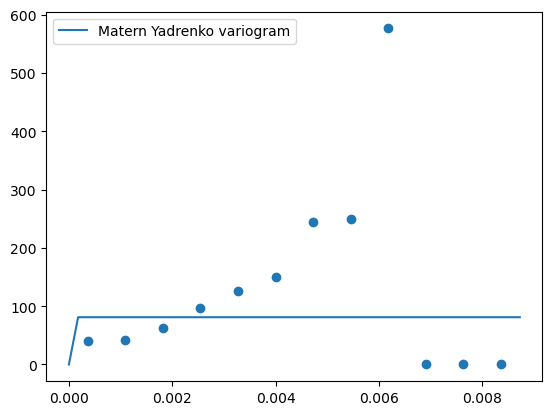

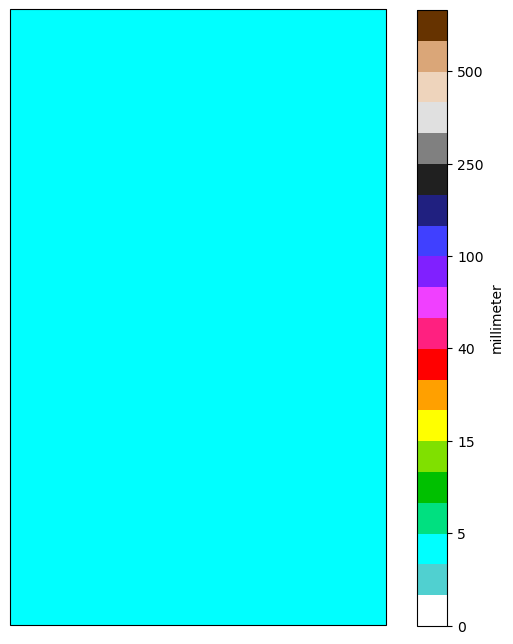

---------------------------------------- Stable ----------------------------------------


/home/akira/anaconda3/envs/p-poteka/lib/python3.7/site-packages/gstools/covmodel/plot.py:156: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


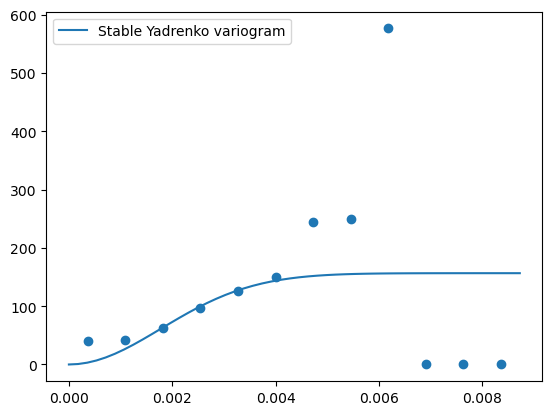

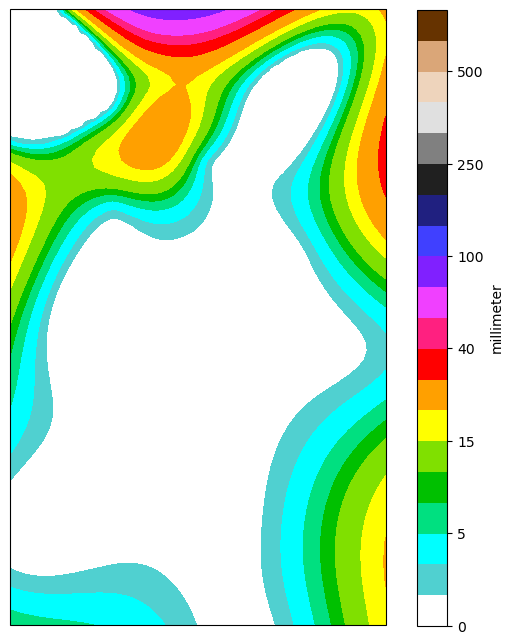

---------------------------------------- Rational ----------------------------------------


/home/akira/anaconda3/envs/p-poteka/lib/python3.7/site-packages/gstools/covmodel/plot.py:156: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


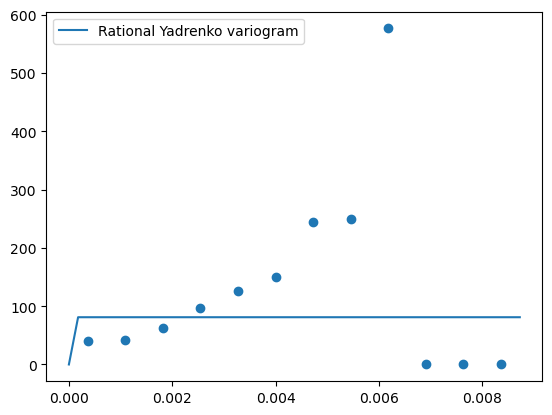

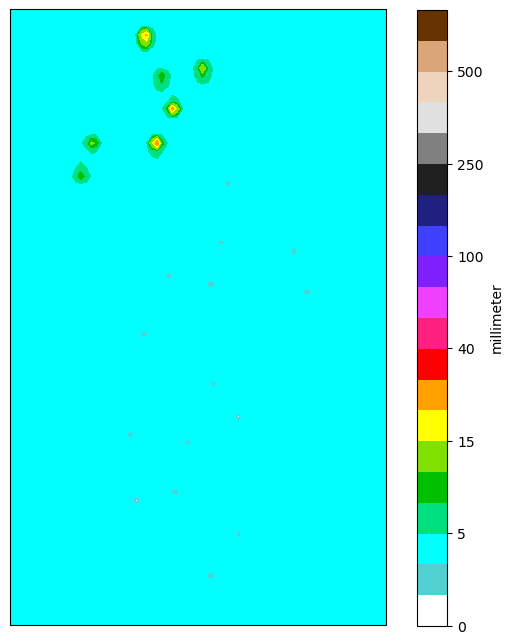

---------------------------------------- Rational ----------------------------------------


/home/akira/anaconda3/envs/p-poteka/lib/python3.7/site-packages/gstools/covmodel/plot.py:156: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


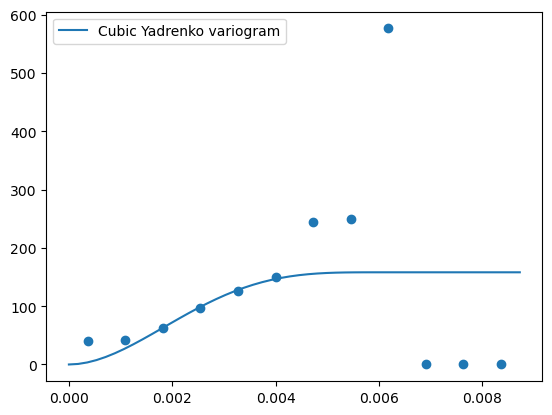

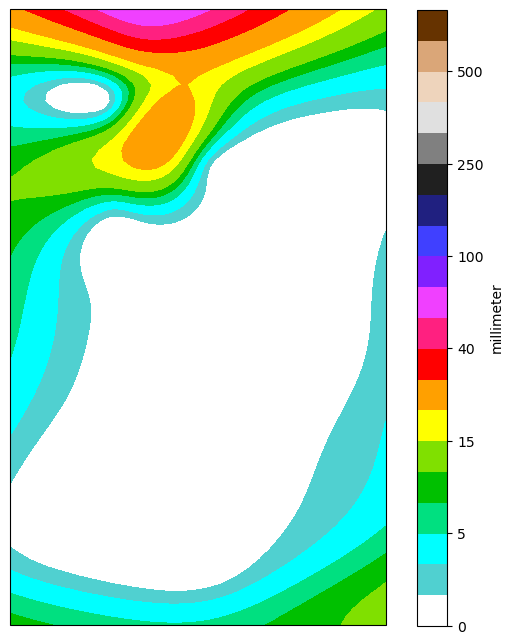

---------------------------------------- Cubic ----------------------------------------


/home/akira/anaconda3/envs/p-poteka/lib/python3.7/site-packages/gstools/covmodel/plot.py:156: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


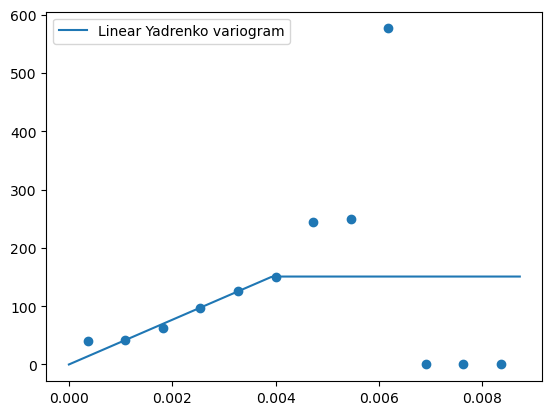

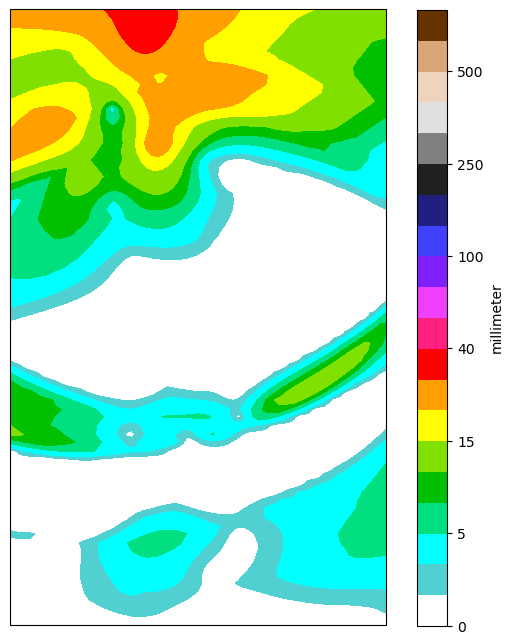

---------------------------------------- Linear ----------------------------------------


/home/akira/anaconda3/envs/p-poteka/lib/python3.7/site-packages/gstools/covmodel/plot.py:156: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


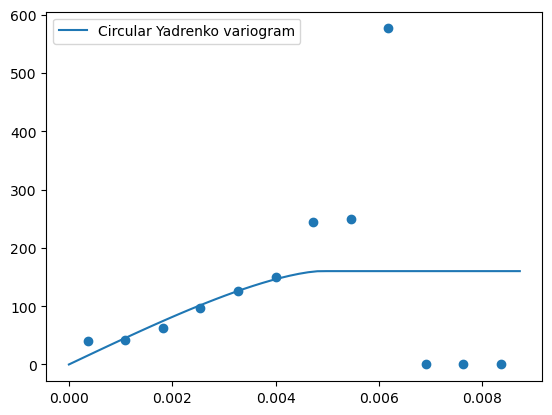

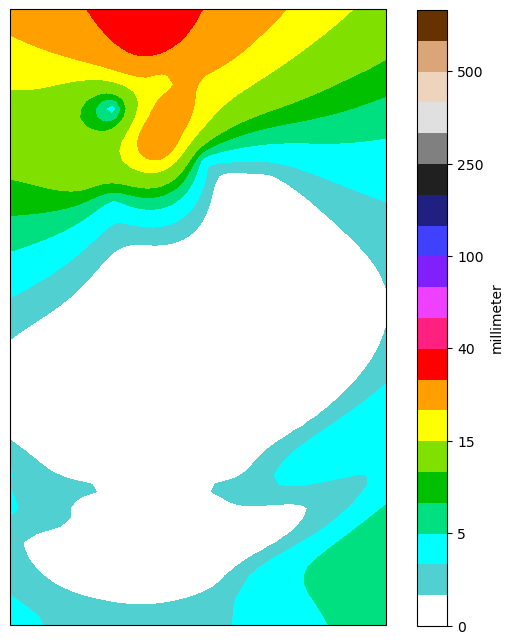

---------------------------------------- Circular ----------------------------------------


/home/akira/anaconda3/envs/p-poteka/lib/python3.7/site-packages/gstools/covmodel/plot.py:156: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


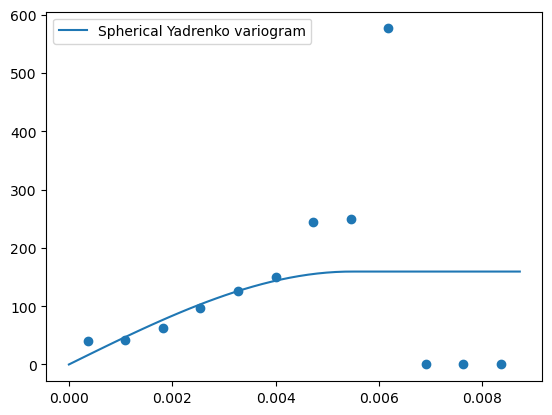

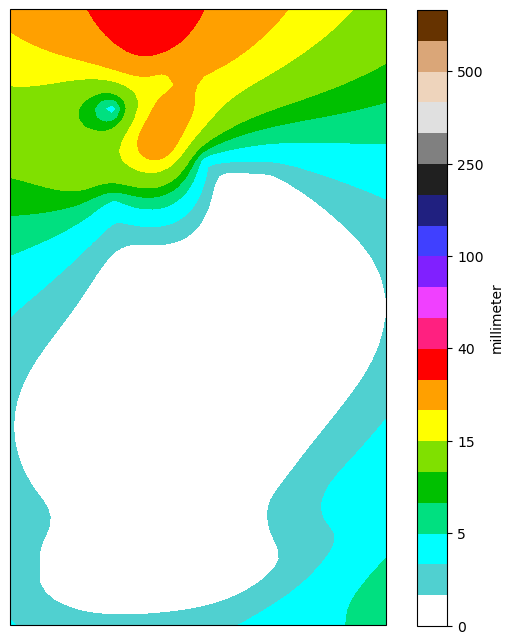

---------------------------------------- Spherical ----------------------------------------


/home/akira/anaconda3/envs/p-poteka/lib/python3.7/site-packages/gstools/covmodel/plot.py:156: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


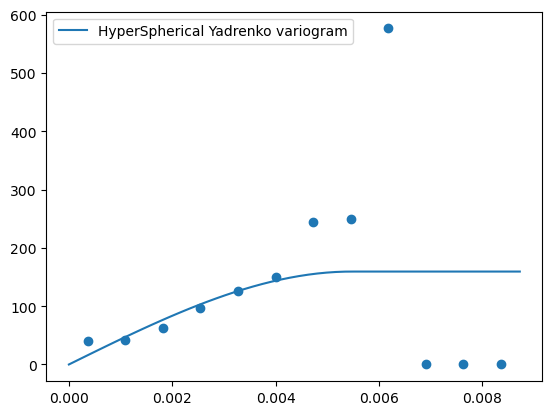

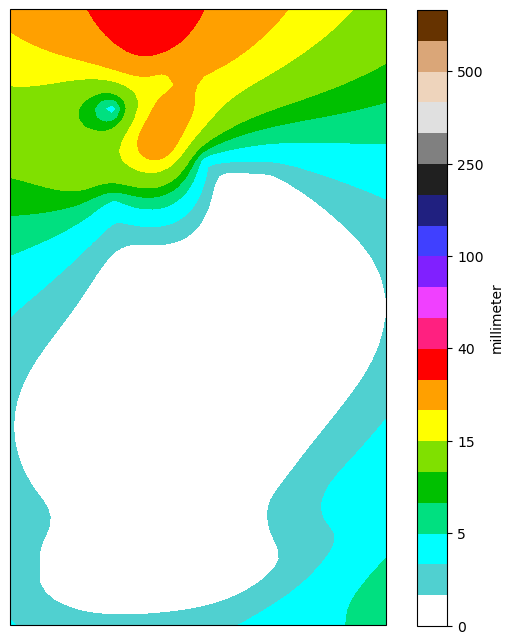

---------------------------------------- HyperShperical ----------------------------------------


/home/akira/anaconda3/envs/p-poteka/lib/python3.7/site-packages/gstools/covmodel/plot.py:156: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


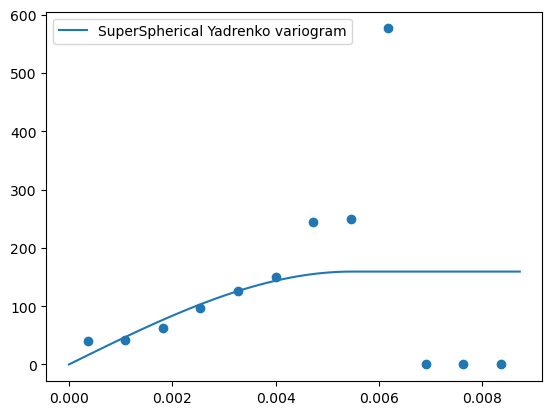

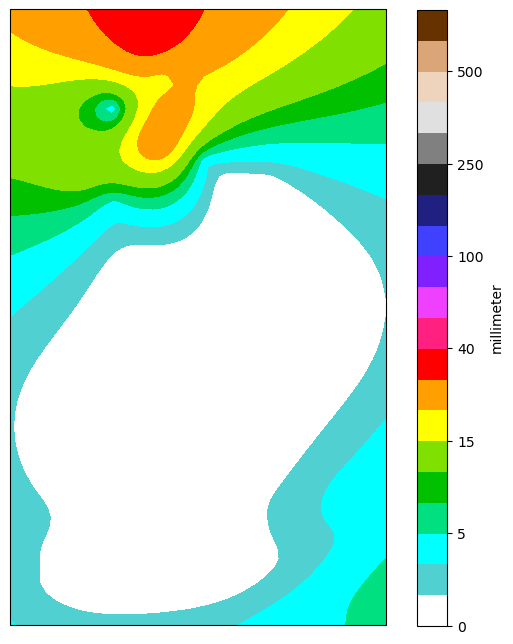

---------------------------------------- SuperSphetrical ----------------------------------------


/home/akira/anaconda3/envs/p-poteka/lib/python3.7/site-packages/gstools/covmodel/plot.py:156: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


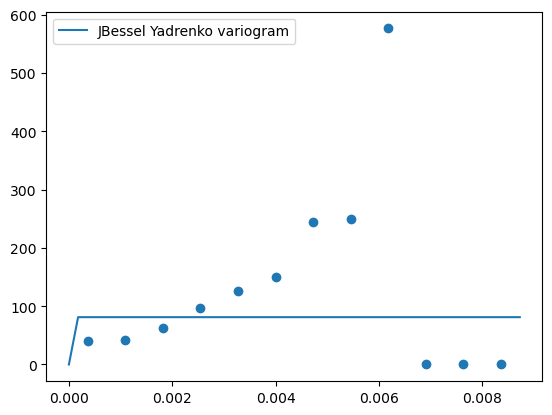

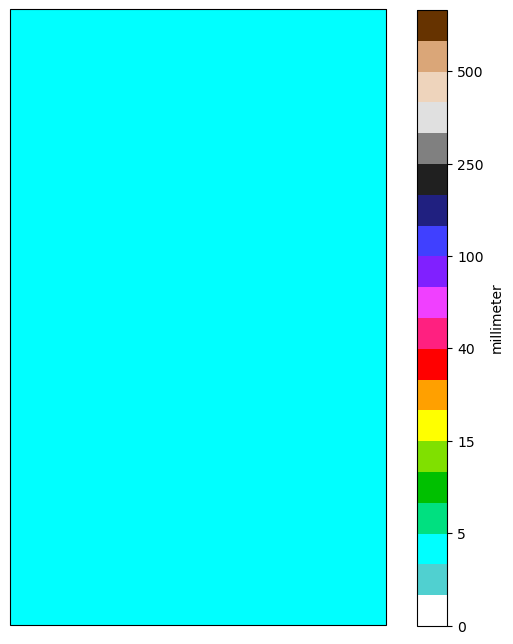

---------------------------------------- JBessel ----------------------------------------


/home/akira/anaconda3/envs/p-poteka/lib/python3.7/site-packages/gstools/covmodel/plot.py:156: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


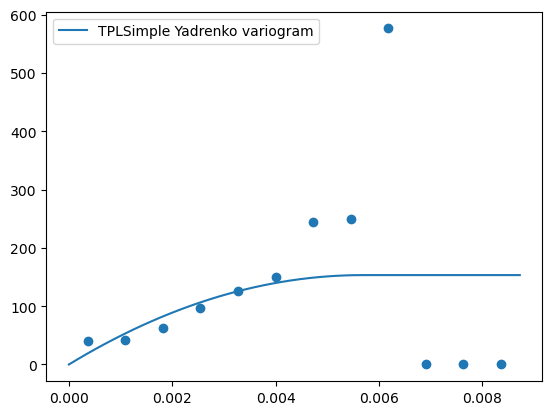

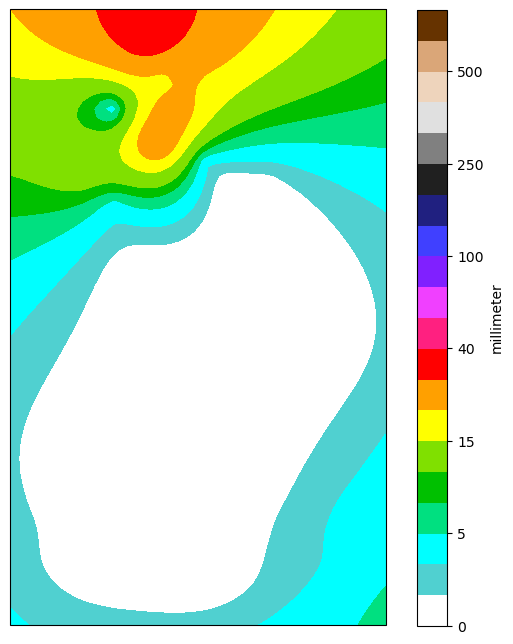

In [6]:
models = [gs.Gaussian(latlon=True, rescale=gs.EARTH_RADIUS, var=0.5, len_scale=1.0),
          gs.Exponential(latlon=True, rescale=gs.EARTH_RADIUS, var=0.5, len_scale=1.0),
          gs.Matern(latlon=True, rescale=gs.EARTH_RADIUS, var=0.5, len_scale=1.0),
          gs.Stable(latlon=True, rescale=gs.EARTH_RADIUS, var=0.5, len_scale=1.0),
          gs.Rational(latlon=True, rescale=gs.EARTH_RADIUS, var=0.5, len_scale=1.0),
          gs.Cubic(latlon=True, rescale=gs.EARTH_RADIUS, var=0.5, len_scale=1.0),
          gs.Linear(latlon=True, rescale=gs.EARTH_RADIUS, var=0.5, len_scale=1.0),
          gs.Circular(latlon=True, rescale=gs.EARTH_RADIUS, var=0.5, len_scale=1.0),
          gs.Spherical(latlon=True, rescale=gs.EARTH_RADIUS, var=0.5, len_scale=1.0),
          gs.HyperSpherical(latlon=True, rescale=gs.EARTH_RADIUS, var=0.5, len_scale=1.0),
          gs.SuperSpherical(latlon=True, rescale=gs.EARTH_RADIUS, var=0.5, len_scale=1.0),
          gs.JBessel(latlon=True, rescale=gs.EARTH_RADIUS, var=0.5, len_scale=1.0),
          gs.TPLSimple(latlon=True, rescale=gs.EARTH_RADIUS, var=0.5, len_scale=1.0)]
model_name = ['Gaussian', 'Exponential', 'Matern', 'Stable', 'Rational', 'Rational', 'Cubic', 'Linear', 'Circular', 'Spherical',
             'HyperShperical', 'SuperSphetrical', 'JBessel', 'TPLSimple']
for i in range(len(models)):
    print('-'*40, model_name[i], '-'*40)
    bins = gs.standard_bins((df['LAT'], df['LON']), max_dist=np.deg2rad(0.5), latlon=True)
    bin_c, vario = gs.vario_estimate((df['LAT'], df['LON']), df['hour-rain'], bins, latlon=True)
    model = models[i]
    model.fit_variogram(bin_c, vario, nugget=False)
    ax = model.plot("vario_yadrenko", x_max=bins[-1])
    ax.scatter(bin_c, vario)
    grid_lon = np.round(np.linspace(120.90, 121.150, 75), decimals=3)
    grid_lat = np.round(np.linspace(14.350, 14.760, 75), decimals=3)
    #z1, ss1 = np.round(OK.execute("grid", grid_lon, grid_lat), decimals=3)
    OK_gs = gs.krige.Ordinary(model, [df['LAT'], df['LON']], df['hour-rain'], exact=True)
    z1 = OK_gs.structured([grid_lat, grid_lon])
    z1 = z1[0]
    xintrip, yintrip = np.meshgrid(grid_lon, grid_lat)
    rain_data = np.where(z1 > 0, z1, 0)
    fig = plt.figure(figsize=(8, 8))
    proj = ccrs.Stereographic(central_latitude=14.555, central_longitude=121.025)
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax.coastlines()

    clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
             50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750]
    cmap_data = [(1.0, 1.0, 1.0),
                 (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
                 (0.0, 1.0, 1.0),
                 (0.0, 0.8784313797950745, 0.501960813999176),
                 (0.0, 0.7529411911964417, 0.0),
                 (0.501960813999176, 0.8784313797950745, 0.0),
                 (1.0, 1.0, 0.0),
                 (1.0, 0.6274510025978088, 0.0),
                 (1.0, 0.0, 0.0),
                 (1.0, 0.125490203499794, 0.501960813999176),
                 (0.9411764740943909, 0.250980406999588, 1.0),
                 (0.501960813999176, 0.125490203499794, 1.0),
                 (0.250980406999588, 0.250980406999588, 1.0),
                 (0.125490203499794, 0.125490203499794, 0.501960813999176),
                 (0.125490203499794, 0.125490203499794, 0.125490203499794),
                 (0.501960813999176, 0.501960813999176, 0.501960813999176),
                 (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
                 (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
                 (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
                 (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
                 (0.4000000059604645, 0.20000000298023224, 0.0)]
    cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
    norm = mcolors.BoundaryNorm(clevs, cmap.N)

    cs = ax.contourf(xintrip, yintrip, rain_data, clevs, cmap=cmap, norm=norm)
    cbar = plt.colorbar(cs, orientation='vertical')
    cbar.set_label('millimeter')
    plt.show()
    plt.close()

In [7]:
clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
             50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750]
cmap_data = [(1.0, 1.0, 1.0),
             (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
             (0.0, 1.0, 1.0),
             (0.0, 0.8784313797950745, 0.501960813999176),
             (0.0, 0.7529411911964417, 0.0),
             (0.501960813999176, 0.8784313797950745, 0.0),
             (1.0, 1.0, 0.0),
             (1.0, 0.6274510025978088, 0.0),
             (1.0, 0.0, 0.0),
             (1.0, 0.125490203499794, 0.501960813999176),
             (0.9411764740943909, 0.250980406999588, 1.0),
             (0.501960813999176, 0.125490203499794, 1.0),
             (0.250980406999588, 0.250980406999588, 1.0),
             (0.125490203499794, 0.125490203499794, 0.501960813999176),
             (0.125490203499794, 0.125490203499794, 0.125490203499794),
             (0.501960813999176, 0.501960813999176, 0.501960813999176),
             (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
             (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
             (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
             (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
             (0.4000000059604645, 0.20000000298023224, 0.0)]
variogram_models = ['linear', 'exponential', 'gaussian', 'spherical']

for model in variogram_models:
    print('-'*40, model, '-'*40)
    OK = OrdinaryKriging(df['LON'], df['LAT'], df['hour-rain'], variogram_model=model, verbose=False, enable_plotting=False)

    grid_lon = np.round(np.linspace(120.90, 121.150, 75), decimals=3)
    grid_lat = np.round(np.linspace(14.350, 14.760, 75), decimals=3)
    z1, ss1 = np.round(OK.execute("grid", grid_lon, grid_lat), decimals=3)
    xintrip, yintrip = np.meshgrid(grid_lon, grid_lat)
    rain_data = np.where(z1 > 0, z1, 0)
    
    
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([120.90, 121.150, 14.350, 14.760])
    ax.add_feature(cfeature.COASTLINE)

    cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
    norm = mcolors.BoundaryNorm(clevs, cmap.N)

    cs = ax.contourf(xintrip, yintrip, rain_data, clevs, cmap=cmap, norm=norm)
    cbar = plt.colorbar(cs, orientation='vertical')
    cbar.set_label('millimeter')
    plt.show()
    plt.close()

---------------------------------------- linear ----------------------------------------


NameError: name 'OrdinaryKriging' is not defined

In [ ]:
def check_model(var, len_scale):
    print('-'*40, var, len_scale, '-'*40)
    bins = gs.standard_bins((df['LAT'], df['LON']), max_dist=np.deg2rad(0.5), latlon=True)
    bin_c, vario = gs.vario_estimate((df['LAT'], df['LON']), df['hour-rain'], bins, latlon=True)
    model = gs.JBessel(latlon=True, rescale=gs.EARTH_RADIUS, var=var, len_scale=len_scale)
    model.fit_variogram(bin_c, vario, nugget=False)
#     ax = model.plot("vario_yadrenko", x_max=bins[-1])
#     ax.scatter(bin_c, vario)
    grid_lon = np.round(np.linspace(120.90, 121.150, 75), decimals=3)
    grid_lat = np.round(np.linspace(14.350, 14.760, 75), decimals=3)
    #z1, ss1 = np.round(OK.execute("grid", grid_lon, grid_lat), decimals=3)
    OK_gs = gs.krige.Ordinary(model, [df['LAT'], df['LON']], df['hour-rain'], exact=True)
    z1 = OK_gs.structured([grid_lat, grid_lon])
    z1 = z1[0]
    xintrip, yintrip = np.meshgrid(grid_lon, grid_lat)
    rain_data = np.where(z1 > 0, z1, 0)
    fig = plt.figure(figsize=(8, 8))
    proj = ccrs.Stereographic(central_latitude=14.555, central_longitude=121.025)
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax.coastlines()

    clevs = [0, 5, 7.5, 10, 15, 20, 30, 40,
             50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750]
    cmap_data = [(1.0, 1.0, 1.0),
                 (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
                 (0.0, 1.0, 1.0),
                 (0.0, 0.8784313797950745, 0.501960813999176),
                 (0.0, 0.7529411911964417, 0.0),
                 (0.501960813999176, 0.8784313797950745, 0.0),
                 (1.0, 1.0, 0.0),
                 (1.0, 0.6274510025978088, 0.0),
                 (1.0, 0.0, 0.0),
                 (1.0, 0.125490203499794, 0.501960813999176),
                 (0.9411764740943909, 0.250980406999588, 1.0),
                 (0.501960813999176, 0.125490203499794, 1.0),
                 (0.250980406999588, 0.250980406999588, 1.0),
                 (0.125490203499794, 0.125490203499794, 0.501960813999176),
                 (0.125490203499794, 0.125490203499794, 0.125490203499794),
                 (0.501960813999176, 0.501960813999176, 0.501960813999176),
                 (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
                 (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
                 (0.8549019694328308, 0.6509804129600525, 0.47058823704719543)]
    cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
    norm = mcolors.BoundaryNorm(clevs, cmap.N)

    cs = ax.contourf(xintrip, yintrip, rain_data, clevs, cmap=cmap, norm=norm)
    cbar = plt.colorbar(cs, orientation='vertical')
    cbar.set_label('millimeter')
    plt.show()
    plt.close()

var_list = [0.1, 0.5, 1, 2, 3, 5, 8]
len_scales = [0.1, 0.5, 1, 2, 3, 5, 8]
for var in var_list:
    for len_scale in len_scales:
        check_model(var, len_scale)

In [ ]:
m_rk.fit()